# Code to extract característics of pants

## Libraries

In [4]:
import cv2
import imutils
import math
import numpy as np
from matplotlib import pyplot as plt
from scipy.ndimage import rotate
from skimage import transform
%matplotlib inline

### Constants

In [5]:
PicRoute = r'Data\OriginalPantsDataset\ReverseDown\IMG_20220329_190241.jpg'

### Extra methods

In [6]:
def showimage(myimage, figsize=[7,7], pltTitle = "", figax =[-1,-1]):
    if (myimage.ndim>2):  #This only applies to RGB or RGBA images (e.g. not to Black and White images)
        myimage = myimage[:,:,::-1] #OpenCV follows BGR order, while matplotlib likely follows RGB order
    if(figax[0] == -1):     
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig = figax[0]
        ax = figax[1]
    ax.imshow(myimage, cmap = 'gray', interpolation = 'bicubic')
    plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    plt.title(pltTitle)
    plt.show()
    
#https://www.freedomvc.com/index.php/2021/10/16/gabor-filter-in-edge-detection/

In [7]:
def loadImage(route, factor=1/8.0, BW = True):
    image = cv2.imread(route)
    image = cv2.resize(image, None, fx=factor, fy=factor, interpolation= cv2.INTER_LINEAR)
    #image = cv2.GaussianBlur(image, (51, 51), 0)
    #sharpFilter = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
    if(BW):
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)       
        #se=cv2.getStructuringElement(cv2.MORPH_RECT , (10,10))
        #bg=cv2.morphologyEx(image, cv2.MORPH_DILATE, se)
        #image=cv2.divide(image, bg, scale=255)
    #image = cv2.filter2D(image, -1, sharpFilter)
    #image = cv2.bitwise_not(image)
    #image = np.array(image, dtype='int')
    return image

## Pas 1: Extració de la peça

La idea seria, primerament s'extreu  la peça de roba de la imatge mitjançant wrinkle i gabor filtering. Primer obrim la imatge

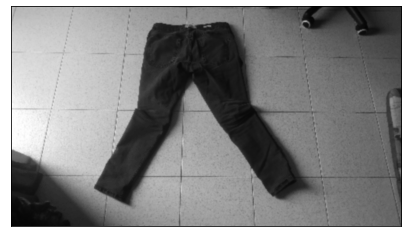

In [8]:
step1image = loadImage(PicRoute)
showimage(step1image)

In [9]:
def create_gaborfilter():
    # This function is designed to produce a set of GaborFilters 
    # an even distribution of theta values equally distributed amongst pi rad / 180 degree
     
    filters = []
    num_filters = 8
    ksize = 35  # The local area to evaluate
    sigma = 4.0
    # Larger Values produce more edges
    lambd = 10.0 #distancia entre picos
    gamma = 0.5 #com d'eliptic
    psi = 0  # Offset value - lower generates cleaner results
    for theta in np.arange(0, np.pi, np.pi / num_filters):  # Theta is the orientation for edge detection
        kern = cv2.getGaborKernel((ksize, ksize), sigma, theta, lambd, gamma, psi, ktype=cv2.CV_64F)
        kern /= 1.0 * kern.sum()  # Brightness normalization
        filters.append(kern)
    return filters
    

In [10]:
def apply_filter(img, filters):
# This general function is designed to apply filters to our image
     
    # First create a numpy array the same size as our input image
    newimage = np.zeros_like(img)
    appliedFilters = []
    # Starting with a blank image, we loop through the images and apply our Gabor Filter
    # On each iteration, we take the highest value (super impose), until we have the max value across all filters
    # The final image is returned
    depth = -1 # remain depth same as original image
     
    for kern in filters:  # Loop through the kernels in our GaborFilter
        image_filter = cv2.filter2D(img, depth, kern)  #Apply filter to image
        # Using Numpy.maximum to compare our filter and cumulative image, taking the higher value (max)
        np.maximum(newimage, image_filter, newimage)        
    #newimage = np.array(newimage, dtype='int')
    return newimage

In [11]:
def calculate_devian(img, filters):
# This general function is designed to apply filters to our image
     
    # First create a numpy array the same size as our input image
    newimage = np.zeros_like(img)
    filteredImage = np.zeros_like(img)
    appliedFilters = []
    # Starting with a blank image, we loop through the images and apply our Gabor Filter
    # On each iteration, we take the highest value (super impose), until we have the max value across all filters
    # The final image is returned
    depth = -1 # remain depth same as original image
     
    for kern in filters:  # Loop through the kernels in our GaborFilter
        image_filter = cv2.filter2D(img, depth, kern)  #Apply filter to image
        # Using Numpy.maximum to compare our filter and cumulative image, taking the higher value (max)
        #np.maximum(newimage, image_filter, newimage)
        appliedFilters.append(image_filter)
        np.maximum(filteredImage, image_filter, filteredImage)        

    for index, pixel in np.ndenumerate(newimage):
        mean = 0;
        x, y = index
        for filtered in appliedFilters:
            pixelValue = filtered[x][y]
            mean += pixelValue
        mean /= len(appliedFilters)
        deviation = 0
        for filtered in appliedFilters:
            pixelValue = filtered[x][y]
            deviation += pow(pixelValue-mean, 2)
        deviation /= len(appliedFilters)
        deviation = math.sqrt(deviation)
        newimage[x,y] = deviation
    #newimage = np.array(newimage, dtype='int')
    return newimage, filteredImage

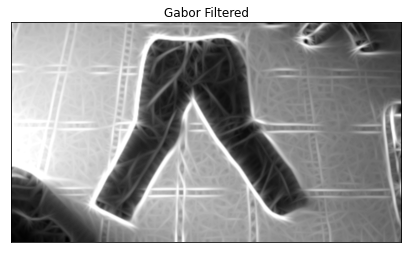

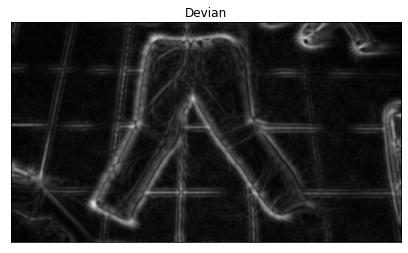

In [17]:
# We create our gabor filters, and then apply them to our image
gfilters = create_gaborfilter()
#image_g = apply_filter(image, gfilters)
image_d, image_g = calculate_devian(step1image, gfilters)
showimage(image_g, pltTitle = "Gabor Filtered")
showimage(image_d, pltTitle = "Devian")

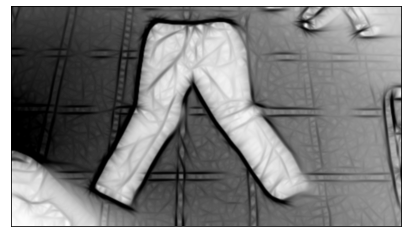

In [22]:
image_g = cv2.bitwise_not(image_g)
showimage(image_g)

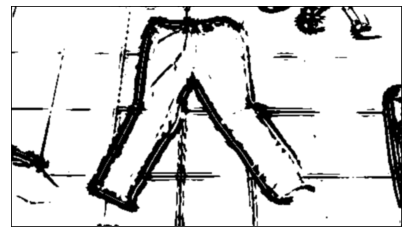

In [24]:
(thresh, blackAndWhiteImage) = cv2.threshold(image_d, 170, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
blackAndWhiteImage = cv2.bitwise_not(blackAndWhiteImage)
showimage(blackAndWhiteImage)

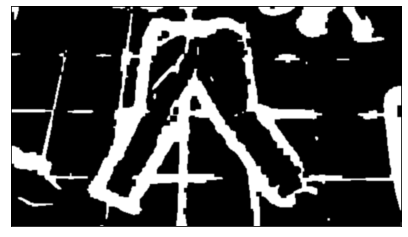

In [33]:
valueClose = int(6)
valueOpen = int(2)
kernelClose = np.ones((valueClose,valueClose),np.uint8)
kernelOpen = np.ones((valueOpen,valueOpen),np.uint8)

imageMask = blackAndWhiteImage.copy()
imageMask = cv2.bitwise_not(blackAndWhiteImage)
imageMask = cv2.morphologyEx(imageMask, cv2.MORPH_DILATE, kernelOpen)
imageMask = cv2.morphologyEx(imageMask, cv2.MORPH_OPEN, kernelOpen)
imageMask = cv2.morphologyEx(imageMask, cv2.MORPH_CLOSE, kernelClose)
showimage(imageMask)

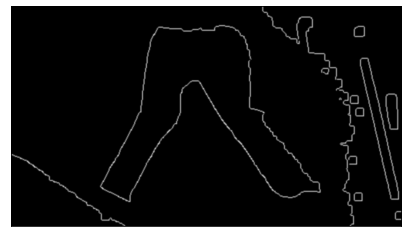

In [78]:
min_interval = 100
max_interval = 250
image_edge_g = cv2.Canny(blackAndWhiteImage,min_interval,max_interval)
 
# Using Numpy's function to append the two images horizontally
showimage(image_edge_g)

# Pas 1 Trampa

In [176]:
def loadImage(route, factor=1/8.0):
    image = cv2.imread(route)
    image = cv2.resize(image, None, fx=factor, fy=factor, interpolation= cv2.INTER_LINEAR)
    return image

In [187]:
def extractBKG(imageRoute, rotateReq = False):
    #Load image
    image = loadImage(imageRoute)
    image = image[10:450, 70:400]

    se=cv2.getStructuringElement(cv2.MORPH_RECT , (10,10))
    image_bg = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image_dil=cv2.morphologyEx(image_bg, cv2.MORPH_DILATE, se)
    (thresh, blackAndWhiteImage) = cv2.threshold(image_dil, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    blackAndWhiteImage = cv2.bitwise_not(blackAndWhiteImage)

    #Clean image
    kernelClose = np.ones((3,3),np.uint8)
    kernelOpen = np.ones((2,2),np.uint8)

    imageMask = blackAndWhiteImage.copy()
    imageMask = cv2.morphologyEx(imageMask, cv2.MORPH_OPEN, kernelOpen)
    imageMask = cv2.morphologyEx(imageMask, cv2.MORPH_CLOSE, kernelClose)

    contours, hierarchy = cv2.findContours(imageMask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    max_contour = max(contours, key=len)
    
    imageMask = np.zeros_like(imageMask, dtype='uint8')
    imageMask = cv2.drawContours(imageMask, [max_contour], -1, (255), thickness=-1)

    #Find ellipse
    (xc,yc),(d1,d2),angle = cv2.fitEllipse(max_contour)
    
    #In case we want it rotated:
    if(rotateReq):
        image = rotate(image, -angle, reshape=True)
        imageMask = rotate(imageMask, -angle, reshape=True)

    return image, imageMask, angle

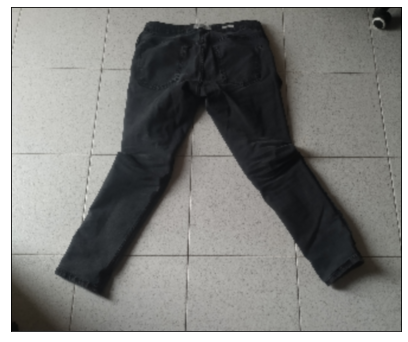

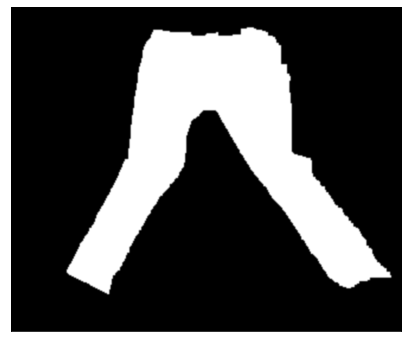

In [188]:
image, imageMask, angle = extractBKG(PicRoute, False)
showimage(image)
showimage(imageMask)

## Pas 2: Parametrització

Despres s'aplica una parametrització per a determinar si la peça en questió es un pantalo o no

### Normalizing and rotating image

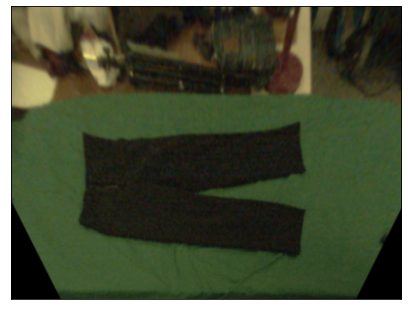

In [12]:
#TEMPORAL
greenImageRoute = r'SimplePants\wide_stereo_optical_frame_birdseye_2010-09-07-20-35-59.png'
step2image = loadImage(greenImageRoute, 1, False)
#step2image = step2image[150:450, 70:550]
showimage(step2image)

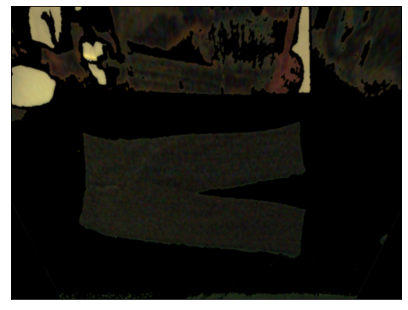

In [13]:
u_green = np.array([103, 199, 149])
l_green = np.array([20, 51, 0])
 
mask = cv2.inRange(step2image, l_green, u_green)
res = cv2.bitwise_and(step2image, step2image, mask = mask)
noBkg = step2image.copy()
noBkg = noBkg-res
showimage(noBkg)

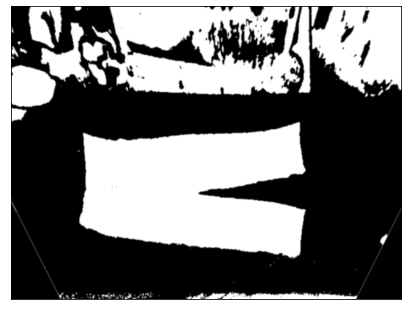

In [14]:
grayRes = cv2.cvtColor(noBkg, cv2.COLOR_BGR2GRAY)
(thresh, blackAndWhiteImage) = cv2.threshold(grayRes, 0, 255, cv2.THRESH_BINARY)
showimage(blackAndWhiteImage)

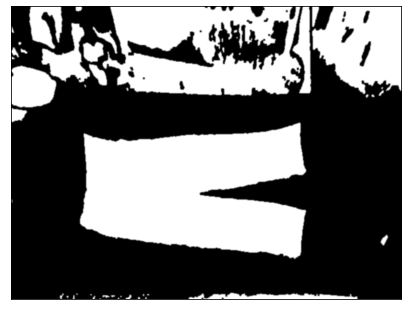

In [15]:
kernelClose = np.ones((3,3),np.uint8)
kernelOpen = np.ones((2,2),np.uint8)

closedImage = blackAndWhiteImage.copy()
closedImage = cv2.morphologyEx(closedImage, cv2.MORPH_OPEN, kernelOpen)
closedImage = cv2.morphologyEx(closedImage, cv2.MORPH_CLOSE, kernelClose)

showimage(closedImage)

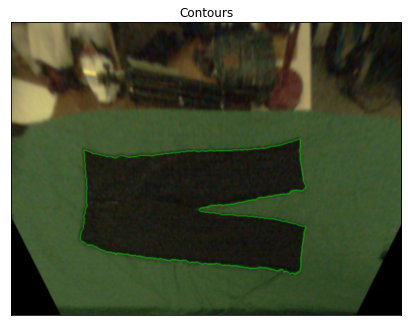

In [16]:
contours, hierarchy = cv2.findContours(closedImage, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
max_contour = max(contours, key=len)
rect = cv2.minAreaRect(max_contour)
cx, cy = rect[0]
w, h = rect[1]
theta = rect[2]

contourImage = cv2.drawContours(step2image.copy(), max_contour, -1, (0, 255, 0), 1)
showimage(contourImage, pltTitle = "Contours")

In [17]:
def rotateImage(image, amount):
    image = rotate(image, -amount, reshape=True)

    #if(amount > 90):
    #    image = cv2.rotate(image, rotateCode = 0)
    #    amount -= 90
    #image = imutils.rotate(image, amount)
    return image

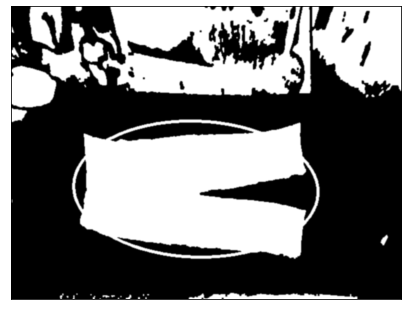

92.12873840332031


In [18]:
ellipse = cv2.fitEllipse(max_contour)
(xc,yc),(d1,d2),angle = ellipse
result = closedImage.copy()
ellipse = cv2.ellipse(result, ellipse, (255, 0, 0), 3)
showimage(ellipse)
print(angle)

In [19]:
#step2image = rotateImage(step2image, angle)
#closedImage = rotateImage(closedImage, angle)
#maskedImage = cv2.bitwise_and(step2image, step2image, mask=closedImage)

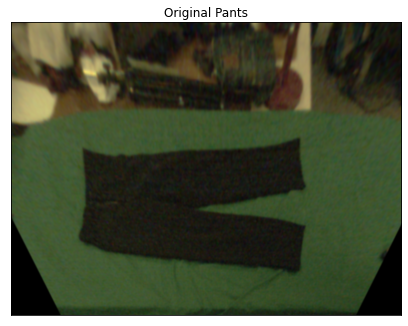

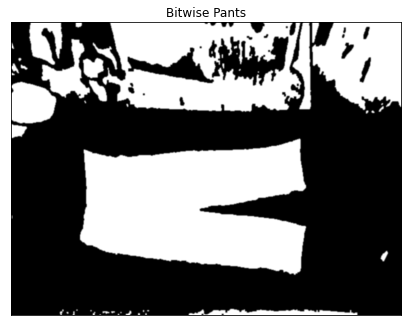

In [20]:
#showimage(maskedImage, pltTitle = "BetterMask Pants")
showimage(step2image, pltTitle = "Original Pants")
showimage(closedImage, pltTitle = "Bitwise Pants")

### Pas 2: Intent 1: Finding corners mitjançant contorns

No funciona perque no cunde

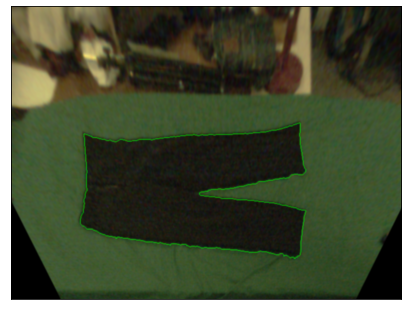

In [21]:
contours, hierarchy = cv2.findContours(closedImage, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
max_contour = max(contours, key=len)
contourImage = cv2.drawContours(step2image.copy(), max_contour, -1, (0, 255, 0), 1)
showimage(contourImage)

Too many lines, needs simplification

In [22]:
iterations = 80

In [23]:
def checkAngle(p1,p2,p3, threshold, drawQuiver = False):
    p1 = p1.astype(float)
    p2 = p2.astype(float)
    p3 = p3.astype(float)
    
    line1 = p2-p1
    line2 = p3-p2
    
    line1 = line1/np.linalg.norm(line1)
    line2 = line2/np.linalg.norm(line2)
    
    dot = np.dot(line1, line2)
    if(drawQuiver):
        plt.quiver([0, 0], [0, 0], line1, line2, angles='xy', scale_units='xy', scale=1)
        plt.xlim(-2, 2)
        plt.ylim(-2, 2)
        plt.show()
    if(dot <= threshold):
        return True
    else: 
        return False
    

In [24]:
max_contour = max(contours, key=len)
originalContour = max_contour
pantsContour = []
for index in originalContour:
    pantsContour.append(index[0])

In [25]:
reducedContours = pantsContour.copy()
for iteration in range(0 , iterations):
    finalPoints = []
    for index in range(0, len(reducedContours)):
        p1Ind = index-2
        if(p1Ind < 0):
            p1Ind = len(reducedContours)-2
        p2Ind = index-1
        if(p2Ind < 0):
            p2Ind = len(reducedContours)-1

        p1 = reducedContours[p1Ind]
        p2 = reducedContours[p2Ind]
        p3 = reducedContours[index]
        if(checkAngle(p1, p2, p3, 0.7)):
            finalPoints.append(reducedContours[p2Ind])
    reducedContours = finalPoints

In [26]:
print('Original lenght of %s' %len(contours[0]))
print('New Lenght of %s'%len(finalPoints))

Original lenght of 2
New Lenght of 4


In [27]:
def drawLines(image, arrayPoints, figsize=[7,7]):
    fig, ax = plt.subplots(figsize=figsize)
    for index in range(0, len(arrayPoints)):
        p1Index = index-1
        if(p1Index < 0):
            p1Index = len(arrayPoints)-1
        p1 = arrayPoints[p1Index]
        p2 = arrayPoints[index]
        plt.plot([p1[0], p2[0]], [p1[1], p2[1]])
    showimage(image, figax = [fig, ax])

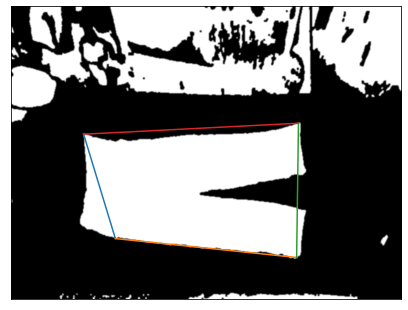

In [28]:
drawLines(closedImage, finalPoints)

### Pas 2: Intent 2: Trobar cantonades a partir de filtre

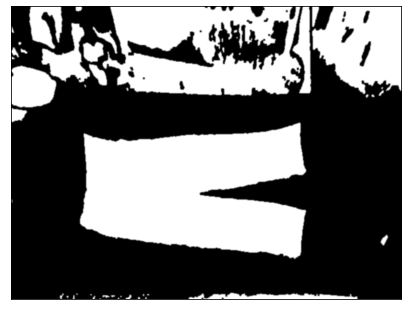

In [29]:
Simplified = closedImage.copy()
kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
Simplified = cv2.filter2D(Simplified, -1, kernel)
showimage(Simplified) #Sharpen

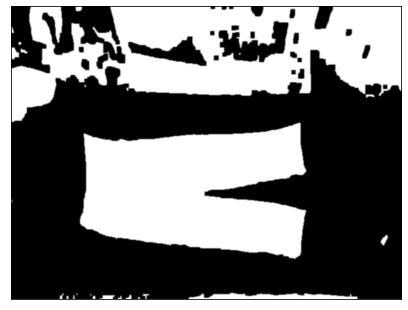

In [30]:
kernelClose = np.ones((7,7),np.uint8)
Simplified = cv2.morphologyEx(Simplified, cv2.MORPH_CLOSE, kernelClose)
showimage(Simplified) #Close holes

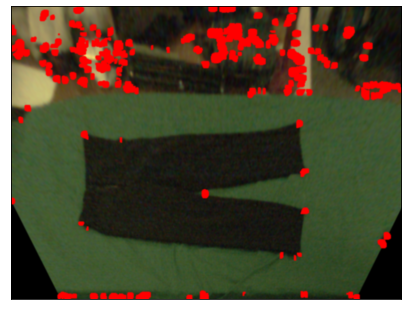

In [31]:
operatedImage = np.float32(Simplified)
 
# apply the cv2.cornerHarris method
# to detect the corners with appropriate
# values as input parameters
dest = cv2.cornerHarris(operatedImage, 9, 13, 0.07)

# Results are marked through the dilated corners
dest = cv2.dilate(dest, None)
 
# Reverting back to the original image,
# with optimal threshold value
imageWithCorners = step2image.copy()
imageWithCorners[dest>0.01*dest.max()] = [0,0,255]
showimage(imageWithCorners)

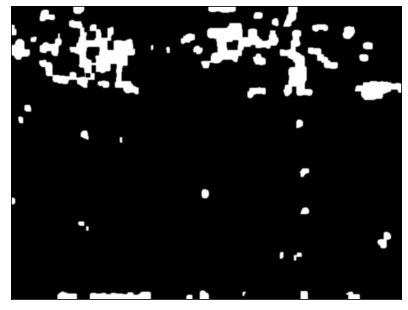

In [32]:
corners = np.zeros_like(dest)
corners[dest>0.01*dest.max()] = [1.]
kernelClose = np.ones((7,7),np.uint8)
corners = cv2.morphologyEx(corners, cv2.MORPH_CLOSE, kernelClose)
showimage(corners)

Ara tenim dues coses interesants, cantonades i edge, utilitzar els dos per a netejar i extreure punts

In [34]:
contours, hierarchy = cv2.findContours(closedImage, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
max_contour = max(contours, key=len)
originalContour = max_contour
pantsContour = []
for index in originalContour:
    pantsContour.append(index[0])

contourImage = cv2.drawContours(step2image.copy(), originalContour, -1, (0, 255, 0), 1)
showimage(contourImage, pltTitle = "Contours")


NameError: name 'closedImage' is not defined

In [35]:
# Obtain outer coordinates
c = max_contour
left = tuple(c[c[:, :, 0].argmin()][0])
right = tuple(c[c[:, :, 0].argmax()][0])
top = tuple(c[c[:, :, 1].argmin()][0])
bottom = tuple(c[c[:, :, 1].argmax()][0])

# Draw dots onto image
cv2.drawContours(image, [c], -1, (36, 255, 12), 2)
cv2.circle(image, left, 8, (0, 50, 255), -1)
cv2.circle(image, right, 8, (0, 255, 255), -1)
cv2.circle(image, top, 8, (255, 50, 0), -1)
cv2.circle(image, bottom, 8, (255, 255, 0), -1)

NameError: name 'max_contour' is not defined

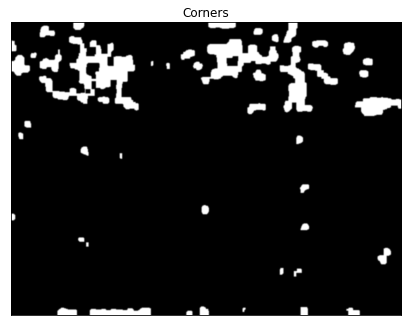

In [34]:
corners = corners.astype(np.uint8)
showimage(corners, pltTitle = "Corners")

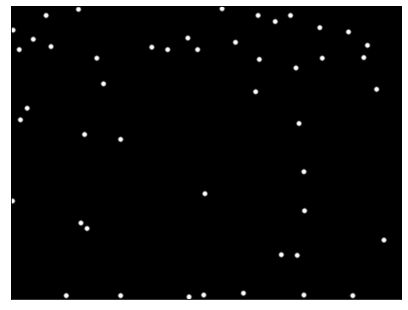

In [35]:
cornerContours, hierarchy = cv2.findContours(corners, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
centers = np.zeros_like(corners)
cornerPoints = []
for i in cornerContours:
    M = cv2.moments(i)
    if M['m00'] != 0:
        cx = int(M['m10']/M['m00'])
        cy = int(M['m01']/M['m00'])
        cv2.circle(centers, (cx, cy), 4, (1), -1)
        cornerPoints.append([cx,cy])
showimage(centers)

In [36]:
minDistance = 5

In [37]:
sortedCorners = []  #Non sorted
nonSorted = cornerPoints.copy() #Points to sort
for point in pantsContour:
    for corner in nonSorted:
        distance = np.linalg.norm(corner-point) #gets length
        if distance < minDistance:
            sortedCorners.append(corner)
            nonSorted.remove(corner)
            break

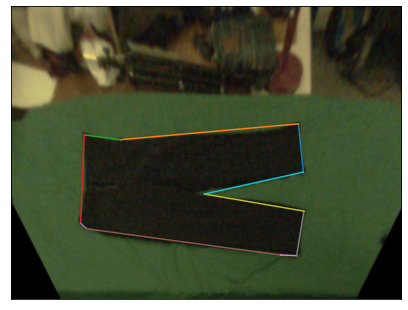

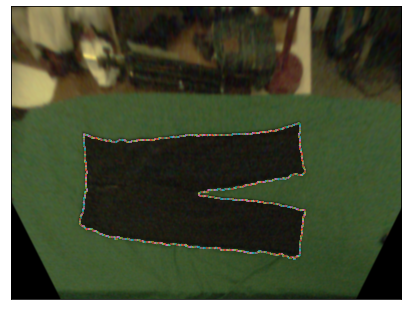

In [38]:
drawLines(step2image,sortedCorners)
drawLines(step2image,pantsContour)

In [39]:
finalCorners = []
for index in range(0, len(sortedCorners)):
    p1Ind = index-2
    if(p1Ind < 0):
        p1Ind = len(sortedCorners)-2
    p2Ind = index-1
    if(p2Ind < 0):
        p2Ind = len(sortedCorners)-1
        
    p1 = np.array(sortedCorners[p1Ind])
    p2 = np.array(sortedCorners[p2Ind])
    p3 = np.array(sortedCorners[index])
    if(checkAngle(p1, p2, p3, 0.7)):
        finalCorners.append(sortedCorners[p2Ind])

They are pants


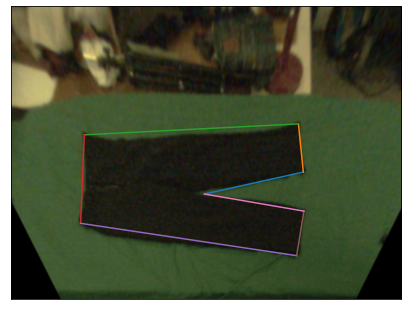

In [40]:
corners = len(finalCorners)
if(corners == 7):
    print("They are pants")
else:
    print("They are not pants")
drawLines(step2image,finalCorners)

# Pas 2: Final code

Gràcies als resultats d'aquest punt, tenim el següent conjunt de funcions

In [190]:
import os
import cv2
import math
import imutils
%matplotlib inline
import numpy as np
from time import sleep
from tqdm.notebook import tqdm
from scipy.ndimage import rotate
from matplotlib import pyplot as plt

In [191]:
def showimage(myimage, figsize=[7,7], pltTitle = "", figax =[-1,-1]):
    if (myimage.ndim>2):  #This only applies to RGB or RGBA images (e.g. not to Black and White images)
        myimage = myimage[:,:,::-1] #OpenCV follows BGR order, while matplotlib likely follows RGB order
    if(figax[0] == -1):     
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig = figax[0]
        ax = figax[1]
    ax.imshow(myimage, cmap = 'gray', interpolation = 'bicubic')
    plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    plt.title(pltTitle)
    plt.show()
    
#https://www.freedomvc.com/index.php/2021/10/16/gabor-filter-in-edge-detection/

In [192]:
def drawLines(image, arrayPoints, figsize=[7,7]):
    fig, ax = plt.subplots(figsize=figsize)
    for index in range(0, len(arrayPoints)):
        p1Index = index-1
        if(p1Index < 0):
            p1Index = len(arrayPoints)-1
        p1 = arrayPoints[p1Index]
        p2 = arrayPoints[index]
        plt.plot([p1[0], p2[0]], [p1[1], p2[1]])
    showimage(image, figax = [fig, ax])

In [193]:
def loadImage(route, factor=1/8.0, BW = True):
    image = cv2.imread(route)
    image = cv2.resize(image, None, fx=factor, fy=factor, interpolation= cv2.INTER_LINEAR)
    #image = cv2.GaussianBlur(image, (51, 51), 0)
    #sharpFilter = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
    if(BW):
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    #image = cv2.filter2D(image, -1, sharpFilter)
    #image = cv2.bitwise_not(image)
    #image = np.array(image, dtype='int')
    return image

In [194]:
def extractBKG(imageRoute, rotateReq = False, greenBKG = True):
    #Load image
    image = loadImage(imageRoute, 1, False)
    image = image[120:700, 0:700]
    
    #Get color filters
    u_green = np.array([103, 199, 149])
    l_green = np.array([38, 94, 0])

    noBkg = image.copy()
    if(greenBKG):
        #Apply color mask
        mask = cv2.inRange(image, l_green, u_green)
        res = cv2.bitwise_and(image, image, mask = mask)
        noBkg = image.copy()
        noBkg = noBkg-res
        
    grayRes = cv2.cvtColor(noBkg, cv2.COLOR_BGR2GRAY)
    if(greenBKG == False):
        grayRes = cv2.bitwise_not(grayRes)
    

    (thresh, blackAndWhiteImage) = cv2.threshold(grayRes, 0, 255, cv2.THRESH_BINARY)

    #Clean image
    kernelClose = np.ones((3,3),np.uint8)
    kernelOpen = np.ones((2,2),np.uint8)

    imageMask = blackAndWhiteImage.copy()
    imageMask = cv2.morphologyEx(imageMask, cv2.MORPH_OPEN, kernelOpen)
    imageMask = cv2.morphologyEx(imageMask, cv2.MORPH_CLOSE, kernelClose)

    contours, hierarchy = cv2.findContours(imageMask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    max_contour = max(contours, key=len)
    
    imageMask = np.zeros_like(imageMask, dtype='uint8')
    imageMask = cv2.drawContours(imageMask, [max_contour], -1, (255), thickness=-1)
    
    #Find ellipse
    (xc,yc),(d1,d2),angle = cv2.fitEllipse(max_contour)
    
    #In case we want it rotated:
    if(rotateReq):
        image = rotate(image, -angle, reshape=True)
        imageMask = rotate(imageMask, -angle, reshape=True)

    return image, imageMask, angle

In [195]:
def checkAngle(p1,p2,p3, threshold, drawQuiver = False):
    p1 = p1.astype(float)
    p2 = p2.astype(float)
    p3 = p3.astype(float)
    
    line1 = p2-p1
    line2 = p3-p2
    line1mag = np.linalg.norm(line1)
    line2mag = np.linalg.norm(line2)
    if(line1mag <= 0.1 or line2mag <= 0.1):
        return False
        
    line1 = line1/np.linalg.norm(line1)
    line2 = line2/np.linalg.norm(line2)
    
    dot = np.dot(line1, line2)
    if(drawQuiver):
        plt.quiver([0, 0], [0, 0], line1, line2, angles='xy', scale_units='xy', scale=1)
        plt.xlim(-2, 2)
        plt.ylim(-2, 2)
        plt.show()
    if(dot <= threshold):
        return True
    else: 
        return False

In [196]:
def extractPantsOutline(image, imageMask, blockSize = 9, ksize = 13, k = 0.07):
    #Preprocessing
    kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
    Simplified = cv2.filter2D(imageMask, -1, kernel) #Sharpen image
    kernelClose = np.ones((7,7),np.uint8)
    Simplified = cv2.morphologyEx(Simplified, cv2.MORPH_CLOSE, kernelClose)
    
    #Get corners through Harris
    operatedImage = np.float32(Simplified)
    dest = cv2.cornerHarris(operatedImage, blockSize, ksize, k) #Input parameters
    dest = cv2.dilate(dest, None) #Get corners
    
    #Making Blobs out of those corners
    corners = np.zeros_like(dest)
    corners[dest>0.01*dest.max()] = [1.]
    kernelClose = np.ones((7,7),np.uint8)
    corners = cv2.morphologyEx(corners, cv2.MORPH_CLOSE, kernelClose)
    
    #Transform corner type
    corners = corners.astype(np.uint8)

    #Getting centers of corners
    cornerContours, hierarchy = cv2.findContours(corners, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    centers = np.zeros_like(corners)
    cornerPoints = []
    for i in cornerContours:
        M = cv2.moments(i)
        if M['m00'] != 0:
            cx = int(M['m10']/M['m00'])
            cy = int(M['m01']/M['m00'])
            cv2.circle(centers, (cx, cy), 4, (1), -1)
            cornerPoints.append([cx,cy])

    #Get Contours of image
    contours, hierarchy = cv2.findContours(imageMask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    pantsContour = max(contours, key=len)
    
    #Sort Corners
    sortedCorners = []  #Non sorted
    for point in pantsContour:
        point = point[0]
        for corner in cornerPoints:
            distance = np.linalg.norm(corner-point) #gets length
            if distance < 5:
                sortedCorners.append(corner)
                cornerPoints.remove(corner)
                break
                
    #Remove unnecessary corners
    finalCorners = []
    for index in range(0, len(sortedCorners)):
        p1Ind = index-2
        if(p1Ind < 0):
            p1Ind = len(sortedCorners)-2
        p2Ind = index-1
        if(p2Ind < 0):
            p2Ind = len(sortedCorners)-1

        p1 = np.array(sortedCorners[p1Ind])
        p2 = np.array(sortedCorners[p2Ind])
        p3 = np.array(sortedCorners[index])
        if(checkAngle(p1, p2, p3, 0.7)):
            finalCorners.append(sortedCorners[p2Ind])
    
    #Final result
    corners = len(finalCorners)
    if(corners == 7):
         return finalCorners, True
    else:
         return finalCorners, False
    return finalCorners

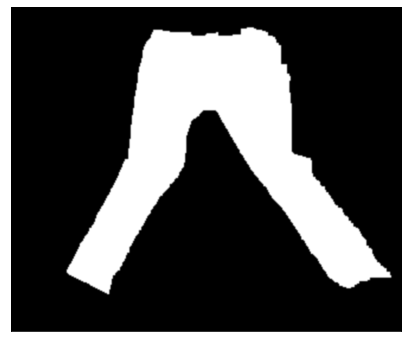

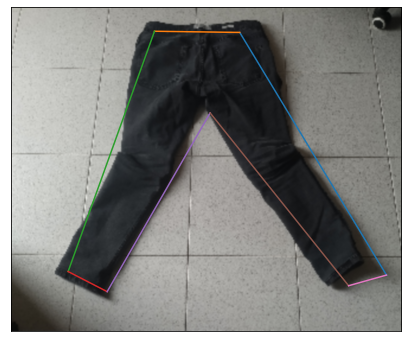

PANTS!
173.6612091064453


In [197]:
#image, imageMask, angle = extractBKG(r'SimplePants\wide_stereo_optical_frame_birdseye_2010-09-07-20-41-00.png', greenBKG = True)
corners, arePants = extractPantsOutline(image, imageMask, 9, 13, 0.07)
showimage(imageMask)
drawLines(image,corners)
if(len(corners) == 7):
    print("PANTS!")
    print(angle)
    

## Finding best combination

In [8]:
def loadImages(route, rotate, greenbkg):
    AllPantsPath = route
    images = [];
    for filename in os.listdir(AllPantsPath):
        f = os.path.join(AllPantsPath, filename)
        # checking if it is a file
        if os.path.isfile(f):
            image, imageMask, _ = extractBKG(f, rotate, greenBKG = greenbkg)
            images.append([image, imageMask])
    return images;

In [50]:
imageList = loadImages(r'SimplePants\Treshold', False, False)

In [51]:
def findBestParameters(imageList):
    bestAccuracy = 0.0
    
    MaxBlock = 15
    MaxAperture = 15
    MaxK = 0.5

    bestBlock = 1
    bestAperture = 1
    bestK = 0.01
    correctChecks = 0
    amountFiles = 0;
    
    for block in tqdm(range(1, MaxBlock)):
        for aperture in tqdm(range(1, MaxAperture, 2)):
            for k in tqdm(np.arange(0.01, MaxK, 0.01)):
                amountFiles = 0
                correctChecks = 0
                for item in imageList:
                    image = item[0].copy()
                    imageMask = item[1].copy()
                    corners, arePants = extractPantsOutline(image, imageMask, block, aperture, k)
                    if(arePants):
                        correctChecks += 1
                    amountFiles += 1
                accuracy = correctChecks/amountFiles
                if(accuracy > bestAccuracy):
                    bestBlock = block
                    bestAperture = aperture
                    bestK = k
                    bestAccuracy = accuracy
                    print("Found better settings. With " + str(bestBlock) + " " + str(bestAperture) +" " +str(bestK))
                    print("Accuracy of " + str(accuracy))
    return bestBlock, bestAperture, bestK

In [52]:
bestBlock, bestAperture, bestK = findBestParameters(imageList)

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

Found better settings. With 2 1 0.01
Accuracy of 0.2620320855614973
Found better settings. With 2 1 0.11
Accuracy of 0.3422459893048128


  0%|          | 0/49 [00:00<?, ?it/s]

Found better settings. With 2 3 0.060000000000000005
Accuracy of 0.39572192513368987


  0%|          | 0/49 [00:00<?, ?it/s]

Found better settings. With 2 5 0.02
Accuracy of 0.5026737967914439


  0%|          | 0/49 [00:00<?, ?it/s]

Found better settings. With 2 7 0.02
Accuracy of 0.5775401069518716


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

Found better settings. With 2 11 0.01
Accuracy of 0.5882352941176471


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

Found better settings. With 3 9 0.03
Accuracy of 0.6310160427807486


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

Found better settings. With 3 13 0.02
Accuracy of 0.6631016042780749


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

Found better settings. With 5 13 0.03
Accuracy of 0.679144385026738
Found better settings. With 5 13 0.04
Accuracy of 0.6898395721925134


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

Found better settings. With 6 13 0.05
Accuracy of 0.6951871657754011


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

Found better settings. With 7 13 0.06999999999999999
Accuracy of 0.7112299465240641


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

Found better settings. With 9 11 0.06999999999999999
Accuracy of 0.7165775401069518
Found better settings. With 9 11 0.09
Accuracy of 0.7219251336898396


  0%|          | 0/49 [00:00<?, ?it/s]

Found better settings. With 9 13 0.06999999999999999
Accuracy of 0.7272727272727273


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

Found better settings. With 10 9 0.09999999999999999
Accuracy of 0.732620320855615


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

# Part 2: Checking accuracy

In [54]:
AllPantsPath = r'SimplePants\Treshold'
correctChecks = 0
amountFiles = 0;
for filename in os.listdir(AllPantsPath):
    f = os.path.join(AllPantsPath, filename)
    # checking if it is a file
    if os.path.isfile(f):
        image, imageMask, _ = extractBKG(f, greenBKG = False)
        corners, arePants = extractPantsOutline(image, imageMask, 10, 9, 0.1)
        if(arePants):
            correctChecks += 1
        #else:
            #showimage(imageMask)
            #drawLines(image,corners)
        amountFiles += 1
print("Out of "+ str(amountFiles) + " there are " + str(correctChecks) + " pants.")
print("Accuracy of " + str(correctChecks/amountFiles))

Out of 187 there are 137 pants.
Accuracy of 0.732620320855615


## Pas 3: Buscar parametres interessants

Detectar a partir patrons com ara arruges, controns i fer una SVM per a determinar i classificar la peça de roba

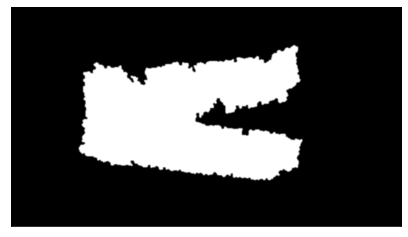

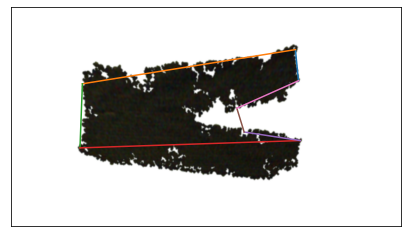

PANTS!


In [53]:
image, imageMask, _ = extractBKG(r'SimplePants\Treshold\wide_stereo_optical_frame_birdseye_2010-09-07-20-35-29_thresh.png', False, greenBKG = False)
corners, arePants = extractPantsOutline(image, imageMask, 9, 13, 0.07)
showimage(imageMask)
drawLines(image,corners)
if(len(corners) == 7):
    print("PANTS!")

Determinar la secció de dalt

In [28]:
print(corners)

[[147, 308], [156, 350], [88, 357], [110, 542], [183, 526], [176, 302], [266, 487]]


In [29]:
distances = []
for index1 in range(0, len(corners)):
    index0 = index1-1
    if(index0 < 0):
        index0 = len(corners)-1
        
    p1 = np.array(corners[index1])
    p0 = np.array(corners[index0])

    distance = np.linalg.norm(p0-p1)
    distances.append([distance, [corners[index0],corners[index1]]])

In [30]:
def partition(arr, low, high):
    i = (low-1)         # index of smaller element
    pivot = arr[high]     # pivot
 
    for j in range(low, high):
 
        # If current element is smaller than or
        # equal to pivot
        if arr[j] >= pivot:
 
            # increment index of smaller element
            i = i+1
            arr[i], arr[j] = arr[j], arr[i]
 
    arr[i+1], arr[high] = arr[high], arr[i+1]
    return (i+1)

In [31]:
def quickSort(arr, low, high):
    if len(arr) == 1:
        return arr
    if low < high:
 
        # pi is partitioning index, arr[p] is now
        # at right place
        pi = partition(arr, low, high)
 
        # Separately sort elements before
        # partition and after partition
        quickSort(arr, low, pi-1)
        quickSort(arr, pi+1, high)

In [32]:
quickSort(distances,0, len(distances)-1)

In [33]:
print(distances)

[[224.1093483101497, [[183, 526], [176, 302]]], [214.94650497274898, [[266, 487], [147, 308]]], [205.73040611440985, [[176, 302], [266, 487]]], [186.30351580150065, [[88, 357], [110, 542]]], [74.73285756613352, [[110, 542], [183, 526]]], [68.3593446428504, [[156, 350], [88, 357]]], [42.95346318982906, [[147, 308], [156, 350]]]]


In [34]:
def drawSingleLines(image, Lines, figsize=[7,7]):
    fig, ax = plt.subplots(figsize=figsize)
    
    for index in range(0, len(Lines)):
        p1 = Lines[index][0]
        p2 = Lines[index][1]
        plt.plot([p1[0], p2[0]], [p1[1], p2[1]])
    showimage(image, figax = [fig, ax])

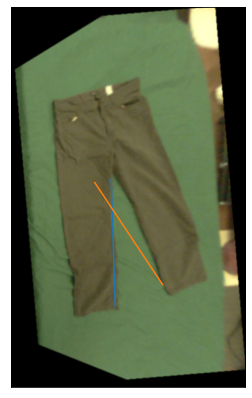

In [35]:
#Legs outside, they are the longest lines
Line1 = distances[0][1]
Line2 = distances[1][1]
Lines = [Line1, Line2]
drawSingleLines(image, Lines)

In [36]:
print(Line1)
print(Line2)

[[183, 526], [176, 302]]
[[266, 487], [147, 308]]


In [37]:
Parallel = distances[4][1]

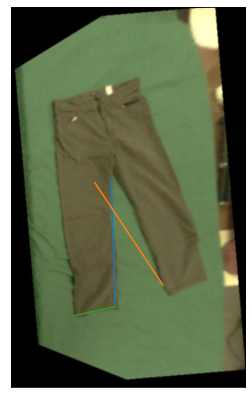

In [38]:
Lines = [Line1, Line2, Parallel]
drawSingleLines(image, Lines)

In [39]:
def findSharingPoint(Line1, Line2):
    if(Line1[0] == Line2[0]):
        return Line1[0]
    else: 
        if(Line1[1] == Line2[0]):
            return Line1[1]
        else:
            return Line2[1]

In [40]:
crotchPoint = findSharingPoint(distances[2][1], distances[3][1])
ParallelVector = np.array(Parallel[1])-np.array(Parallel[0])
CrotchLine = [crotchPoint, crotchPoint + ParallelVector]

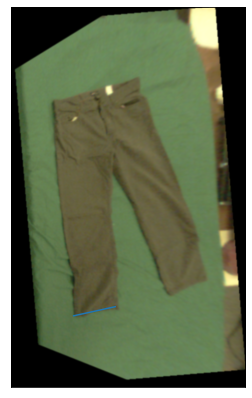

In [41]:
drawSingleLines(image, [CrotchLine])

In [42]:
def findIntersection(Line1, Line2):
        A = Line1[0]
        B = Line1[1]
        
        C = Line2[0]
        D = Line2[1]
        a1 = B[1] - A[1];
        b1 = A[0] - B[0];
        c1 = a1 * (A[0]) + b1 * (A[1]);
  
        a2 = D[1] - C[1];
        b2 = C[0] - D[0];
        c2 = a2 * (C[0]) + b2 * (C[1]);
  
        determinant = a1 * b2 - a2 * b1;
  
        if determinant == 0:
            print("Parallel")
        else:
            x = int((b2 * c1 - b1 * c2) / determinant);
            y = int((a1 * c2 - a2 * c1) / determinant);
            return [x,y];

In [43]:
#CrotchLine
intersection1 = findIntersection(Line1, CrotchLine)
intersection2 = findIntersection(Line2, CrotchLine)
intersectionLine = [intersection1, intersection2]

In [44]:
#ShortenedLines
corner1 = findIntersection(Line1, Parallel)
lineCorner1 = [corner1, intersection1]

corner2 = findIntersection(Line2, Parallel)
lineCorner2 = [corner2, intersection2]

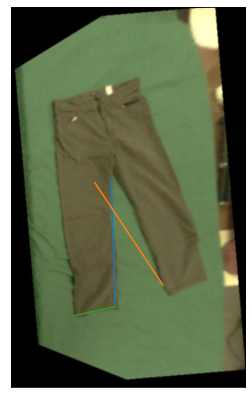

In [45]:
SingleLines = [intersectionLine, lineCorner1, lineCorner2, Parallel]
drawSingleLines(image, Lines)

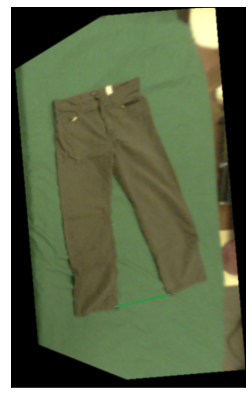

In [46]:
#Back to points
FinalPoints = np.float32([corner1, intersection1, intersection2, corner2])
drawLines(image, FinalPoints)

In [47]:
targetCoordinates = np.float32([[0,0], [0,255], [255,255], [255,0]])

In [48]:
matrix = cv2.getPerspectiveTransform(FinalPoints, targetCoordinates)
result = cv2.warpPerspective(image, matrix, (255, 255))

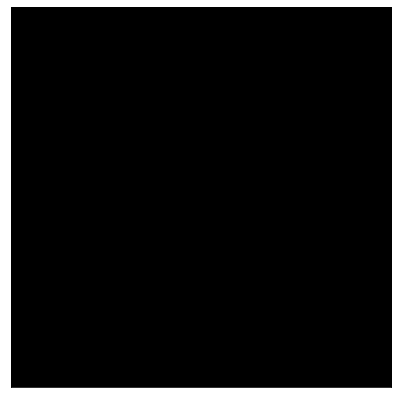

In [49]:
showimage(result)

# Step 3: Resultats

Executar step 2: Resultats

In [198]:
def loadImages(route, rotate, greenbkg):
    AllPantsPath = route
    images = [];
    for filename in os.listdir(AllPantsPath):
        f = os.path.join(AllPantsPath, filename)
        # checking if it is a file
        if os.path.isfile(f):
            image, imageMask, _ = extractBKG(f, rotate, greenBKG = greenbkg)
            images.append([image, imageMask])
    return images;

In [199]:
def partition(arr, low, high):
    i = (low-1)         # index of smaller element
    pivot = arr[high]     # pivot
 
    for j in range(low, high):
 
        # If current element is smaller than or
        # equal to pivot
        if arr[j] >= pivot:
 
            # increment index of smaller element
            i = i+1
            arr[i], arr[j] = arr[j], arr[i]
 
    arr[i+1], arr[high] = arr[high], arr[i+1]
    return (i+1)

In [200]:
def findIntersection(Line1, Line2):
        A = Line1[0]
        B = Line1[1]
        
        C = Line2[0]
        D = Line2[1]
        a1 = B[1] - A[1];
        b1 = A[0] - B[0];
        c1 = a1 * (A[0]) + b1 * (A[1]);
  
        a2 = D[1] - C[1];
        b2 = C[0] - D[0];
        c2 = a2 * (C[0]) + b2 * (C[1]);
  
        determinant = a1 * b2 - a2 * b1;
  
        if determinant == 0:
            print("Parallel")
        else:
            x = int((b2 * c1 - b1 * c2) / determinant);
            y = int((a1 * c2 - a2 * c1) / determinant);
            return [x,y];

In [201]:
def quickSort(arr, low, high):
    if len(arr) == 1:
        return arr
    if low < high:
 
        # pi is partitioning index, arr[p] is now
        # at right place
        pi = partition(arr, low, high)
 
        # Separately sort elements before
        # partition and after partition
        quickSort(arr, low, pi-1)
        quickSort(arr, pi+1, high)

In [202]:
def findSharingPoint(Line1, Line2):
    if(Line1[0] == Line2[0]):
        return Line1[0]
    else: 
        if(Line1[1] == Line2[0]):
            return Line1[1]
        else:
            return Line2[1]

In [203]:
def getTopPants(image, imageMask, corners):
    #We get distances between all consecutive points
    distances = []
    for index1 in range(0, len(corners)):
        index0 = index1-1
        if(index0 < 0):
            index0 = len(corners)-1

        p1 = np.array(corners[index1])
        p0 = np.array(corners[index0])

        distance = np.linalg.norm(p0-p1)
        distances.append([distance, [corners[index0],corners[index1]]])
    
    #The list gets sorted
    quickSort(distances,0, len(distances)-1)
    
    #Get the two longest lines
    Line1 = distances[0][1]
    Line2 = distances[1][1]

    #Get the waist line
    WaistPoints = distances[4][1]
    
    #We find the crotch point
    crotchPoint = findSharingPoint(distances[2][1], distances[3][1])
    WaistLine = np.array(WaistPoints[1])-np.array(WaistPoints[0])
    
    #Create crotch line in parallel to waistLine
    CrotchLine = [crotchPoint, crotchPoint + WaistLine]
    
    #Find intersection point between crotch line and longest one
    intersection1 = findIntersection(Line1, CrotchLine)
    intersection2 = findIntersection(Line2, CrotchLine)
    
    #New points with crotch and longest lines
    corner1 = findIntersection(Line1, WaistPoints)
    corner2 = findIntersection(Line2, WaistPoints)
    
    #Order all the points
    FinalPoints = np.float32([corner1, intersection1, intersection2, corner2])

    #New size
    targetCoordinates = np.float32([[0,0], [0,255], [255,255], [255,0]])
    
    #Wrap image to fit
    matrix = cv2.getPerspectiveTransform(FinalPoints, targetCoordinates)
    result = cv2.warpPerspective(image, matrix, (255, 255))
    return result

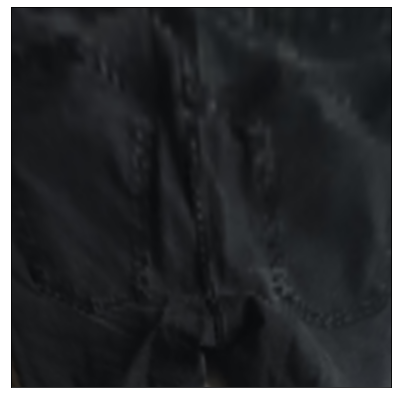

In [204]:
#image, imageMask, _ = extractBKG(r'SimplePants\wide_stereo_optical_frame_birdseye_2010-09-07-20-41-57.png', True, greenBKG = True)
#corners, arePants = extractPantsOutline(image, imageMask, 9, 13, 0.07)
if(len(corners) == 7):
    result = getTopPants(image, imageMask, corners)
    showimage(result)

In [24]:
def saveImages(imageRoute, finalRoute,rotate, bkg):
    imageList = loadImages(imageRoute,rotate, bkg).copy()
    for index in range(0,len(imageList)):
        image = imageList[index][0]
        imageMask = imageList[index][1]
        corners, arePants = extractPantsOutline(image, imageMask, 10, 9, 0.1)
        if(arePants):
            result = getTopPants(image, imageMask, corners)
            finalDest = os.path.join(finalRoute,str(index) + '.png')
            cv2.imwrite(finalDest, result)
            print(index)

In [25]:
saveImages(r'SimplePants\Treshold', r'SimplePants\Focused', False, False)

0
1
5
6
8
9
10
12
14
15
16
17
19
20
21
22
23
24
25
27
28
29
30
32
33
34
35
36
37
38
39
42
43
45
46
47
50
51
52
53
55
57
59
60
61
62
63
64
65
66
68
69
70
71
72
73
75
77
78
81
82
83
84
85
86
87
88
89
90
93
94
95
97
98
99
100
101
104
106
107
108
109
110
111
112
113
114
115
117
119
120
121
122
123
124
125
126
127
128
129
131
132
133
134
135
138
140
142
143
144
145
146
152
154
155
156
157
158
161
162
163
164
165
167
168
170
171
176
177
178
179
180
181
182
183
184
186


Crear un nou script, amb el codi en questio, com a pack

Que no es perdi resolució a la imatge final